In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.lines import Line2D
from textwrap import wrap
from matplotlib import gridspec

# %matplotlib inline

palette = sns.color_palette("colorblind")

In [339]:
df = pd.read_csv('frontline_workers.csv')
df = df[['Job', 'Demographic', 'Level', 'count']]

In [340]:
def add_sums_pcts(input: pd.DataFrame) -> pd.DataFrame:
    input['total'] = input.groupby(['Job', 'Demographic'])['count'].transform('sum')
    input['pct'] = input['count']/input['total']
    return(input)

In [341]:
# do the transformations
out = add_sums_pcts(df)

In [409]:
# Basic info
out.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183 entries, 0 to 182
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Job          183 non-null    object 
 1   Demographic  183 non-null    object 
 2   Level        183 non-null    object 
 3   count        183 non-null    int64  
 4   total        183 non-null    int64  
 5   pct          183 non-null    float64
dtypes: float64(1), int64(2), object(3)
memory usage: 8.7+ KB


In [408]:
# numerics
out.describe()
# out.isnull().sum()


,count,total,pct
count,183.000000,183.000000,183.000000
mean,6308.885246,22054.032787,0.295082
std,16002.492704,37611.829321,0.282198
min,6.000000,470.000000,0.006977
25%,239.000000,1823.000000,0.074036
50%,814.000000,5067.000000,0.212766
75%,4213.500000,15260.000000,0.407200
max,110142.000000,122113.000000,0.985189


In [305]:
# basic descriptive stats
categorical  = out.select_dtypes(exclude=['number']).columns.to_list()
{cat: df[cat].value_counts() for cat in categorical}

{'Job': Job
 Total Frontline                          21
 Grocery, Convenience, & Drug Stores      21
 Health Care                              21
 Childcare & Social Services              21
 Education and Support (K-12)             21
 All Workers                              21
 Trucking, Warehouse, & Postal Service    20
 Building Cleaning Services               19
 Public Transit                           18
 Name: count, dtype: int64,
 'Demographic': Demographic
 Age Group           45
 Education level     44
 Race/Ethnicity      40
 Gender              18
 Foreign born        18
 Health Insurance    18
 Name: count, dtype: int64,
 'Level': Level
 White            9
 Black            9
 Uninsured        9
 Immigrant        9
 Non-Immigrant    9
 Female           9
 Male             9
 College          9
 Some college     9
 HS               9
 LTHS             9
 65+              9
 55-64            9
 35-54            9
 25-34            9
 16-24            9
 Insured          9

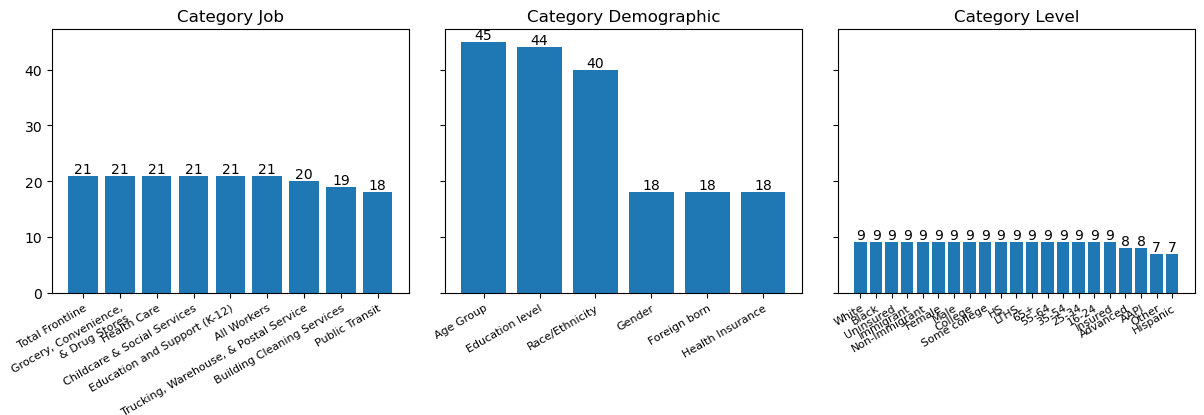

In [300]:
# Set up the number of subplots in advance because that is known
fig = fig, axes = plt.subplots(1, len(categorical), figsize=(12, 4), sharey=True)

# for each of the subplots, create it
for i, cat in enumerate(categorical):
    ax = axes[i]                       # if we expand into two rows, we need to calculate this correctly
    plot_dat = df[cat].value_counts()
    bar = ax.bar(plot_dat.index, plot_dat.values)
    ax.bar_label(bar, fmt='{:,.0f}')
    ax.set_title(f'Category {cat}')
    ax.set_xticks(plot_dat.index)
    ax.set_xticklabels(plot_dat.index, rotation=30, size = 8, wrap = True, ha = "right")

plt.tight_layout()

In [273]:

## get the Race/Ethnicity Subset
re_plot = out[out["Demographic"] == "Race/Ethnicity"]

## Calculate the positions as part of the dataframe. Its much easier to manipulate up here
re_plot = re_plot.sort_values(by = ["Job", "Level"], ascending = [False, True])
re_plot['cum_pct'] = re_plot.groupby('Job')['pct'].transform(lambda x:  x.cumsum() - x)
re_plot['midpoint'] = re_plot.groupby('Job')['pct'].transform(lambda x:  x.cumsum() - x/2)

## extract the levels
jobs = re_plot["Job"].unique()
levels = re_plot["Level"].unique()

## establish our palette
palette = sns.color_palette("colorblind")
colors = palette[:len(levels)]
color_dict = dict(zip(levels, colors))

# dictionary to translate the vertical height for each of the bars
y_dict = dict(zip(jobs, np.arange(len(jobs))))



In [306]:
## one way to do the whole thing in a for loop
# fig, ax = plt.subplots(figsize=(9.2, 5))

# for i, (_, row) in enumerate(re_plot.iterrows()):
#     y = y_dict[row["Job"]]
#     width = row["pct"]
#     start = row["cum_pct"]
#     color = color_dict[row["Level"]]
#     ax.barh(y, width , left = start, height = 0.7, color= color)

#     if width > 0.05:
#        midpoint = row["midpoint"]
#        ax.text(midpoint, y, f'{width*100:.1f}%', ha='center', va='center', color='white', fontsize=10)


/var/folders/hs/f91yk2396f3850v077bfmkcm0000gn/T/ipykernel_66830/442204106.py:39: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


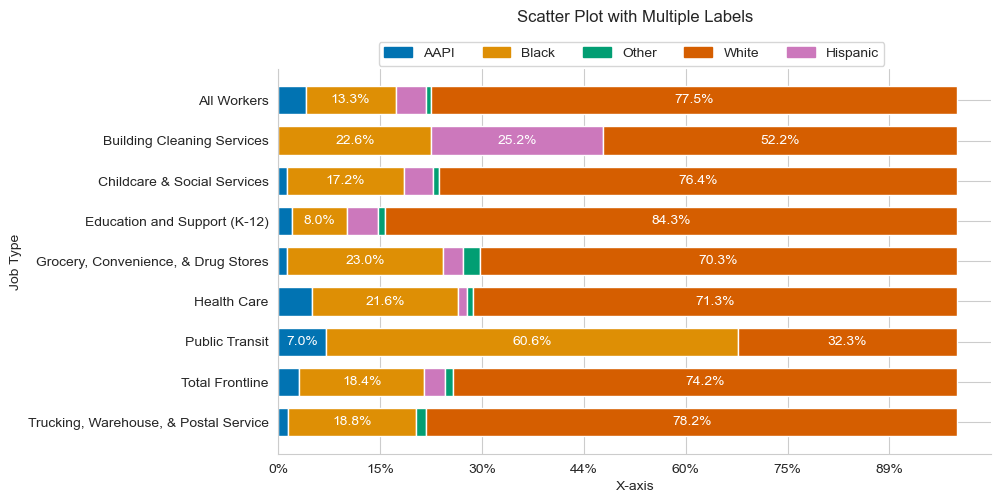

In [394]:
fig, ax = plt.subplots(figsize=(9.2, 5))

# you can do the plot directly if you have the points already calculated
y = re_plot["Job"].transform(lambda x: y_dict[x])
width = re_plot["pct"]
start = re_plot["cum_pct"]
color = re_plot["Level"].transform(lambda x: color_dict[x])

ax.barh(y, width , left = start, height = 0.7, color= color)

# we do need a for loop to add in the labels
midpoint = re_plot["midpoint"]
for x, y, label in zip(midpoint, y, width):
    if label > .05:
        ax.text(x, y, f'{label*100:.1f}%', ha='center', va='center', color='white', fontsize=10)

# Add Labels

## Title
ax.set_title('Scatter Plot with Multiple Labels', y=1.1)

## Y Axis
ax.set_ylabel('Job Type')
wrapped_labels = ['\n'.join(wrap(label, width=60)) for label in jobs]
ax.set_yticks(range(len(jobs)), wrapped_labels)
    
## X Axis
ax.set_xlabel('X-axis')
ax.set_xticks(np.arange(0, 1, .15))
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x*100)}%'))

## Legend 
handles = [plt.Rectangle((0,0), 1, 1, color=color_dict[level]) for level in levels]
ax.legend(handles, levels, bbox_to_anchor=(0.85,1.07),  borderaxespad=0 , ncol=len(levels))

## Remove unnecessary lines
ax.spines[['right', 'top']].set_visible(False)

fig.show()



/var/folders/hs/f91yk2396f3850v077bfmkcm0000gn/T/ipykernel_66830/1749327780.py:6: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  ax = sns.barplot(x='pct_display', y='Job', hue= 'Level', data=re_plot, errorbar=None, palette= palette, orient='h')


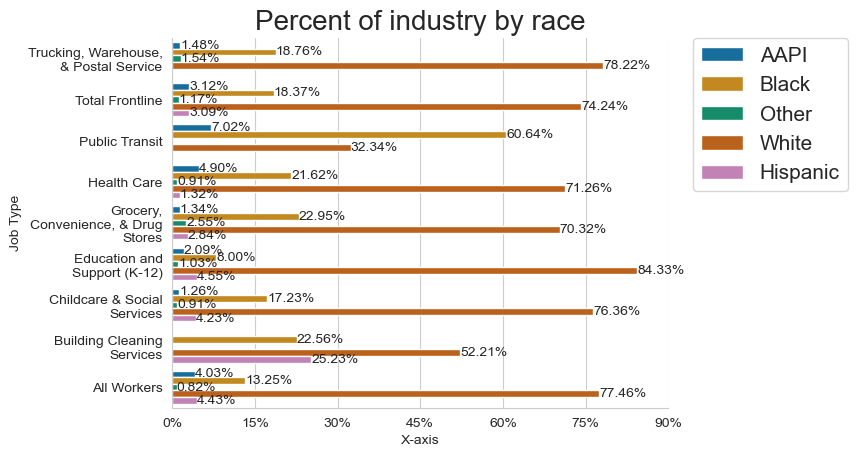

In [ ]:
# Normal Bar Plots
sns.set_style("whitegrid") ## set style up top

## Do the bar plot
re_plot['pct_display'] = re_plot['pct'] * 100 ## because we are woring with percents, do this quick transformation to set it up. 
ax = sns.barplot(x='pct_display', y='Job', hue= 'Level', data=re_plot, errorbar=None, palette= palette, orient='h')
[ax.bar_label(c, fmt = '%.2f%%') for c in ax.containers]

## Title
ax.set_title("Percent of industry by race", fontsize=20)

## X Axis
ax.set_xlabel('X-axis')
ax.set_xticks(np.arange(0, 100, 15))
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}%'))

## Y Axis
ax.set_ylabel('Job Type')
wrapped_labels = ['\n'.join(wrap(label, width=20)) for label in jobs]
ax.set_yticks(jobs, wrapped_labels)


plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=15)
# ax.grid(False)

## Remove unnecessary spines
ax.spines[['right', 'top']].set_visible(False)

plt.show()


# Scatter Plots

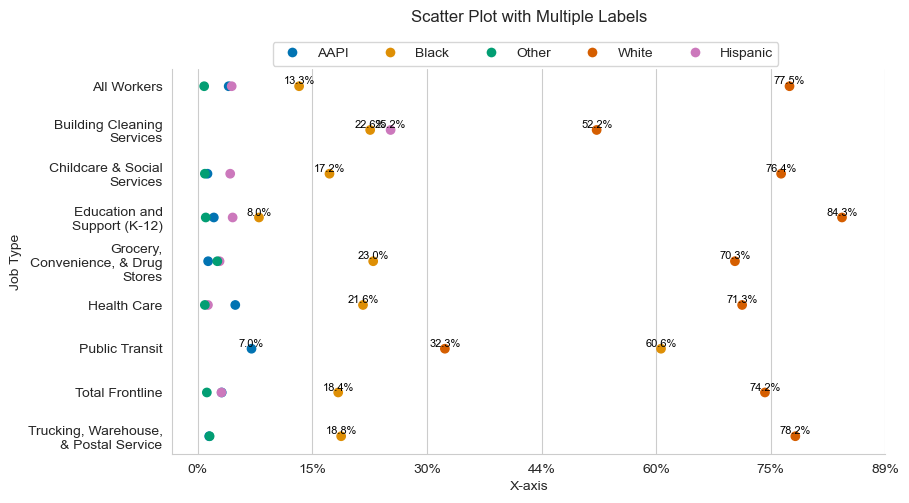

In [401]:
## Scatter plot
fig, ax = plt.subplots(1, 1, figsize=(9.2, 5))

# you can do the plot directly if you have the points already calculated
y = re_plot["Job"]
x = re_plot["pct"]
color = re_plot["Level"].transform(lambda x: color_dict[x])
ax.scatter(x, y , color= color)

for x, y in zip(x, y):
    if x > .05:
        ax.text(x, y, f'{x*100:.1f}%', ha='center', va='bottom', color='black', fontsize=8)

# Add Labels
## Title
ax.set_title('Scatter Plot with Multiple Labels', y=1.1)

## Y Axis
ax.set_ylabel('Job Type')
wrapped_labels = ['\n'.join(wrap(label, width=20)) for label in jobs]
ax.set_yticks(jobs, wrapped_labels)
    
## X Axis
ax.set_xlabel('X-axis')
ax.set_xticks(np.arange(0, 1, .15))
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x*100)}%'))

## Legend 
handles = [Line2D([], [], marker='o',  color = "white", markerfacecolor= color_dict[level], markersize= 8) for level in levels] ## this does circles
ax.legend(handles, levels, bbox_to_anchor=(0.85,1.07),  borderaxespad=0 , ncol=len(levels))

## Remove unnecessary lines
ax.spines[['right', 'top']].set_visible(False)
plt.grid(axis='y')



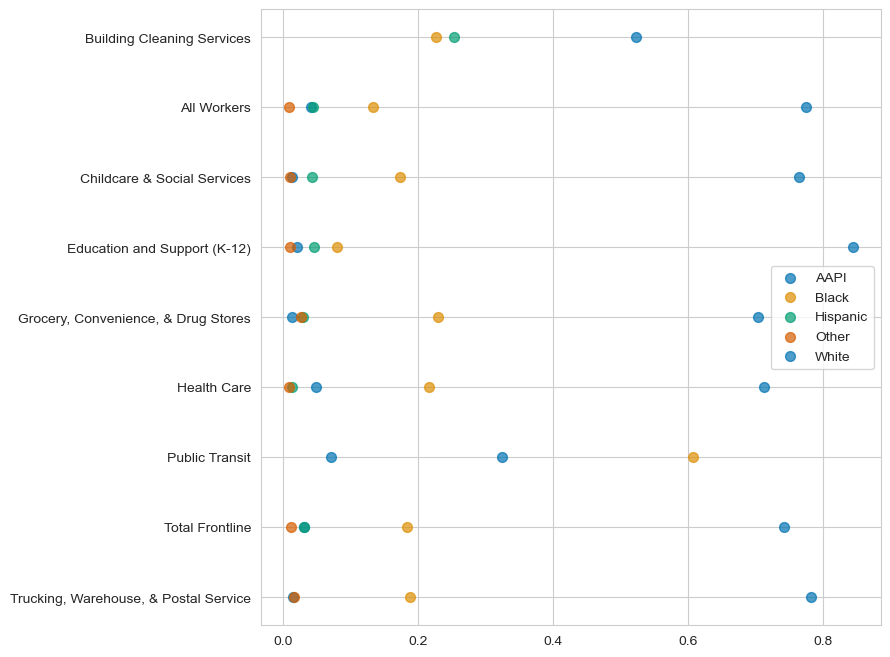

In [407]:
# Another way to do this
y = re_plot["Job"].values
x = re_plot["pct"].values
COLORS = re_plot["Level"].transform(lambda x: color_dict[x])
LEVELS = re_plot['Level'].values
LEVELS_ = np.unique(LEVELS)

fig, ax = plt.subplots(figsize=(8,8))

for level, color in zip(LEVELS_, COLORS):
    idxs = np.where(LEVELS == level)
    ax.scatter(
        x[idxs], y[idxs], label=level,
        s=50, color=color, alpha=0.7
    )
    
ax.legend()
plt.show()

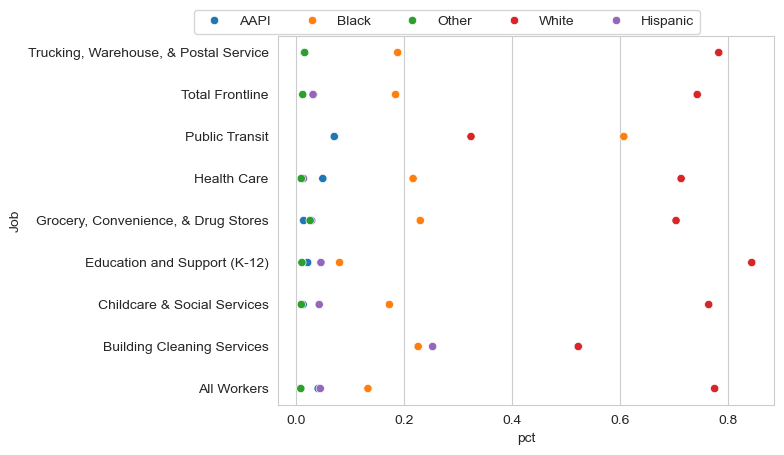

In [391]:
## you can also just do this with seaborn
sns.scatterplot(data=re_plot, x="pct", y="Job", hue="Level")
plt.legend(bbox_to_anchor=(0.85,1.07),  borderaxespad=0, ncol = 5)
ax.grid(False)

## Remove unnecessary lines
ax.spines[['right', 'top']].set_visible(False)
plt.grid(axis='y')


## relplot has both scatter and line



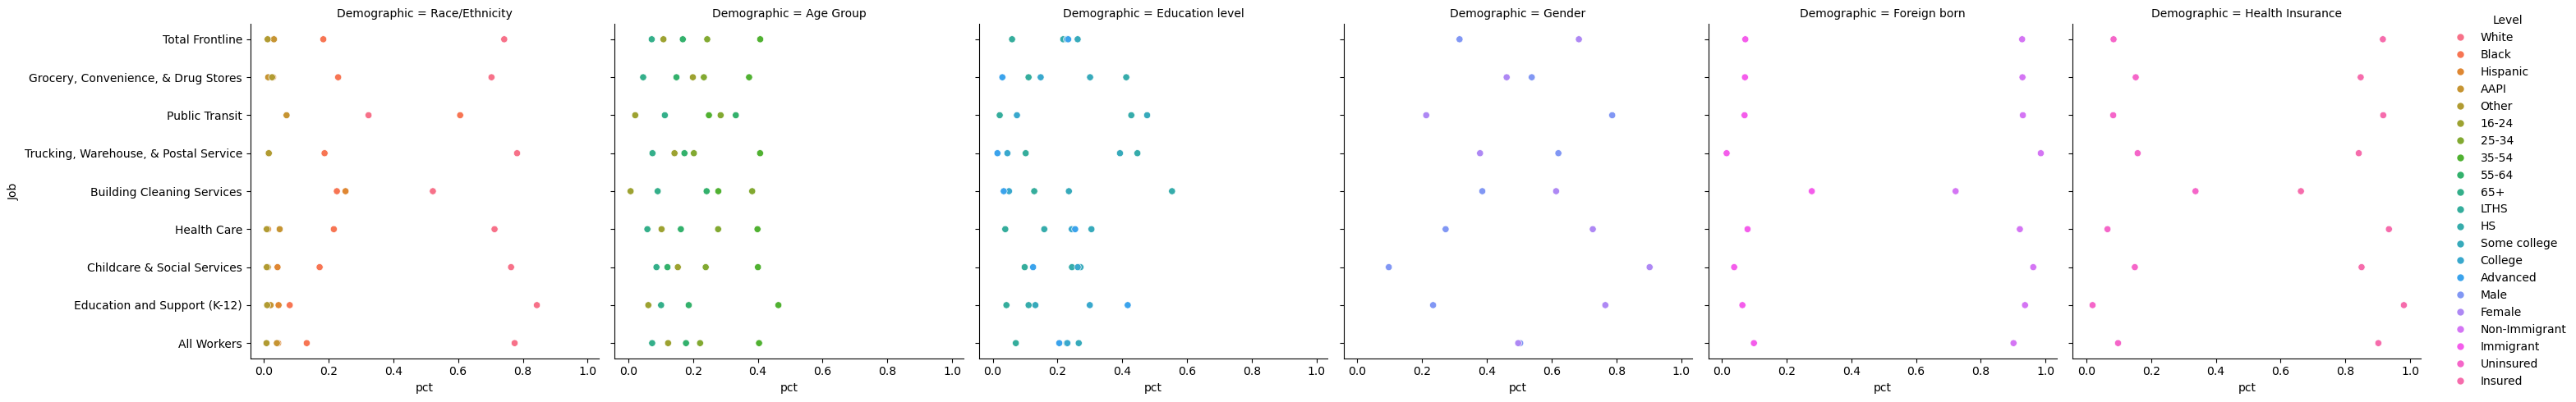

In [359]:
sns.relplot(
    data=out, x="pct", y="Job",
    col="Demographic", hue="Level", 
    kind="scatter"
)

# Garbage Can

In [ ]:
# fig, ax = plt.subplots(figsize=(9.2, 5))

# for i, level in enumerate(reversed(levels)):
#     plot_dat = re_plot[re_plot["Level"] == level]
#     values = plot_dat['pct'].to_list()
#     ax.barh(y_pos, values, left = left_positions, height=0.5, color= colors[i])
#     left_positions = left_positions + values

# for i, (_,row) in enumerate(re_plot.iterrows()):
#     plt.text(pos + ratio/2, i, f'{ratio*100:.1f}%', 
#                        ha='center', va='center', color='white', fontsize=10, fontweight='bold')
#             pos += ratio
    

## -------------------


# fig = plt.Figure()

# # fig, axes = plt.subplots(1, len(categories), figsize=(12, 4), sharey=True)

# gs = gridspec.GridSpec(len(categorical), 1, hspace = 1.2)  ## this is setting up the display grid
# all_axes = []

# for i, cat in enumerate(categorical):
#     ax = fig.add_subplot(gs[i, 0])
#     all_axes.append(ax)

#     plot_dat = df[cat].value_counts()
#     ax.bar(plot_dat.index, plot_dat.values)
#     ax.set_xticklabels(plot_dat.index, rotation=30, size = 8, wrap = True, ha = "right")
#     ax.set_title(cat)

# # set a standard y axis
# y_max = max([ax.get_ylim()[1] for ax in all_axes])

# for ax in all_axes:
#     ax.set_ylim(0, y_max)

# plt.tight_layout()
# fig


